## Tranfer Learning with Tensorflow Part 2: Fine-Tuning


In [1]:
# Cheak gpu
!nvidia-smi

Thu Oct 26 22:41:53 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 529.04       Driver Version: 529.04       CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name            TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ... WDDM  | 00000000:01:00.0  On |                  N/A |
| N/A   48C    P8     3W /  93W |    496MiB /  8188MiB |      6%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## create a helper function

So, repetative functions we can put in script and import in our notebooks

https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py




In [2]:
# !wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

In [2]:
amol = ['a','m','o','l']

TypeError: list indices must be integers or slices, not str

In [3]:
# Import helper functions we'er going to use in this notebook

from helper_functions import create_tensorboard_callback, plot_loss_curves, unzip_data, walk_through_dir

## Let's get some data

`tf.keras.applications`

In [4]:
# get 10% of training data
# !wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip

unzip_data("10_food_classes_10_percent.zip")

In [5]:
# Check out how many images and subdirectories are in dataset
walk_through_dir("10_food_classes_10_percent")

There are 3 directories and 0 images in '10_food_classes_10_percent'.
There are 10 directories and 0 images in '10_food_classes_10_percent\test'.
There are 0 directories and 250 images in '10_food_classes_10_percent\test\chicken_curry'.
There are 0 directories and 250 images in '10_food_classes_10_percent\test\chicken_wings'.
There are 0 directories and 250 images in '10_food_classes_10_percent\test\fried_rice'.
There are 0 directories and 250 images in '10_food_classes_10_percent\test\grilled_salmon'.
There are 0 directories and 250 images in '10_food_classes_10_percent\test\hamburger'.
There are 0 directories and 250 images in '10_food_classes_10_percent\test\ice_cream'.
There are 0 directories and 250 images in '10_food_classes_10_percent\test\pizza'.
There are 0 directories and 250 images in '10_food_classes_10_percent\test\ramen'.
There are 0 directories and 250 images in '10_food_classes_10_percent\test\steak'.
There are 0 directories and 250 images in '10_food_classes_10_percent

In [6]:
# Create training and test directories paths
train_dir = "10_food_classes_10_percent/train"
test_dir = "10_food_classes_10_percent/test"

In [7]:
from keras.src.utils import image_dataset
import tensorflow as tf
IMG_SIZE =(224, 224)
BATCH_SIZE = 32
train_data_10_percent = tf.keras.preprocessing.image_dataset_from_directory(directory=train_dir,
                                                                            image_size=IMG_SIZE,
                                                                            label_mode="categorical",
                                                                            batch_size=BATCH_SIZE)

test_data = tf.keras.preprocessing.image_dataset_from_directory(directory= test_dir,
                                                                image_size= IMG_SIZE,
                                                                label_mode="categorical",
                                                                batch_size=BATCH_SIZE)

Found 750 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


In [8]:
train_data_10_percent

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 10), dtype=tf.float32, name=None))>

In [9]:
# Check out the class names of our dataset

train_data_10_percent.class_names

['chicken_curry',
 'chicken_wings',
 'fried_rice',
 'grilled_salmon',
 'hamburger',
 'ice_cream',
 'pizza',
 'ramen',
 'steak',
 'sushi']

In [10]:
# See an example of a batch of data
for images, labels in train_data_10_percent.take(1):
  print(images, labels)

tf.Tensor(
[[[[1.00000000e+00 1.00000000e+00 3.00000000e+00]
   [1.00000000e+00 1.00000000e+00 2.12946439e+00]
   [1.00000000e+00 1.00000000e+00 1.00000000e+00]
   ...
   [1.00000000e+00 1.00000000e+00 1.00000000e+00]
   [1.00000000e+00 1.00000000e+00 1.00000000e+00]
   [1.45111084e-01 1.45111084e-01 1.45111084e-01]]

  [[1.00000000e+00 1.00000000e+00 1.00000000e+00]
   [1.00000000e+00 1.00000000e+00 1.00000000e+00]
   [1.00000000e+00 1.00000000e+00 1.00000000e+00]
   ...
   [1.00000000e+00 1.00000000e+00 1.00000000e+00]
   [1.00000000e+00 1.00000000e+00 1.00000000e+00]
   [1.45111084e-01 1.45111084e-01 1.45111084e-01]]

  [[1.00000000e+00 1.00000000e+00 1.00000000e+00]
   [1.00000000e+00 1.00000000e+00 1.00000000e+00]
   [1.00000000e+00 1.00000000e+00 1.00000000e+00]
   ...
   [1.00000000e+00 1.00000000e+00 1.00000000e+00]
   [1.00000000e+00 1.00000000e+00 1.00000000e+00]
   [3.28301668e-01 3.28301668e-01 3.28301668e-01]]

  ...

  [[0.00000000e+00 2.85491085e+00 0.00000000e+00]
   [0

## Model 0 : Building a tranfer learning model using  the Keras Functional API

In [11]:
# 1. Create a base model tf.keras.application

base_model = tf.keras.applications.efficientnet_v2.EfficientNetV2B0(include_top=False)

# 2. freeze the base model
base_model.trainable = False

# 3. Create inputs into our model
inputs = tf.keras.layers.Input(shape=(224,224,3), name="input_layer")

# 4. for resnet

# 5. Pass the inputs to the base model
x = base_model(inputs)
print(f"Shape after passing inputs through base model: {x.shape}")

# 6. Avarage pool outputs of the model (aggregation all the most important information, reduce number of computations)
x = tf.keras.layers.GlobalAveragePooling2D(name = "Gloabal_average_pooling_layer")(x)
print(f"Shape after GlobalAveragePooling2D: {x.shape}")

# 7. Create the output activation layer
outputs = tf.keras.layers.Dense(10, activation="softmax", name="output_layer")(x)

# 8. combine the inputes with the outputs into a model
model_0 = tf.keras.Model(inputs, outputs)

#9. Compile the model
model_0.compile(loss= "categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

# 10. fit the model

history_10_percent = model_0.fit(train_data_10_percent,
                                 epochs = 5,
                                 steps_per_epoch=len(train_data_10_percent),
                                 validation_data=test_data,
                                 validation_steps=int(0.25 * len(test_data)),
                                 callbacks = [create_tensorboard_callback(dir_name= "transfer_learning",
                                                                          experiment_name="10_percent_feature_extraction")])



Shape after passing inputs through base model: (None, 7, 7, 1280)
Shape after GlobalAveragePooling2D: (None, 1280)
Saving TensorBoard log files to: transfer_learning/10_percent_feature_extraction/20231026-224217
Epoch 1/5
24/24 [==============================] - 22s 682ms/step - loss: 1.9534 - accuracy: 0.3453 - val_loss: 1.3950 - val_accuracy: 0.7089
Epoch 2/5
24/24 [==============================] - 14s 608ms/step - loss: 1.1768 - accuracy: 0.7467 - val_loss: 0.9671 - val_accuracy: 0.7780
Epoch 3/5
24/24 [==============================] - 15s 616ms/step - loss: 0.8523 - accuracy: 0.8107 - val_loss: 0.7887 - val_accuracy: 0.8191
Epoch 4/5
24/24 [==============================] - 15s 619ms/step - loss: 0.6913 - accuracy: 0.8480 - val_loss: 0.6778 - val_accuracy: 0.8306
Epoch 5/5
24/24 [==============================] - 15s 633ms/step - loss: 0.6000 - accuracy: 0.8547 - val_loss: 0.5839 - val_accuracy: 0.8487


In [12]:
# Evaluate on the full test dataset

model_0.evaluate(test_data)

79/79 [==============================] - 35s 446ms/step - loss: 0.5748 - accuracy: 0.8536


[0.5748327374458313, 0.853600025177002]

In [13]:
# Check the layers in our base model model
for layer_number, layer in enumerate(base_model.layers):
  print(layer_number, layer.name)


0 input_1
1 rescaling
2 normalization
3 stem_conv
4 stem_bn
5 stem_activation
6 block1a_project_conv
7 block1a_project_bn
8 block1a_project_activation
9 block2a_expand_conv
10 block2a_expand_bn
11 block2a_expand_activation
12 block2a_project_conv
13 block2a_project_bn
14 block2b_expand_conv
15 block2b_expand_bn
16 block2b_expand_activation
17 block2b_project_conv
18 block2b_project_bn
19 block2b_drop
20 block2b_add
21 block3a_expand_conv
22 block3a_expand_bn
23 block3a_expand_activation
24 block3a_project_conv
25 block3a_project_bn
26 block3b_expand_conv
27 block3b_expand_bn
28 block3b_expand_activation
29 block3b_project_conv
30 block3b_project_bn
31 block3b_drop
32 block3b_add
33 block4a_expand_conv
34 block4a_expand_bn
35 block4a_expand_activation
36 block4a_dwconv2
37 block4a_bn
38 block4a_activation
39 block4a_se_squeeze
40 block4a_se_reshape
41 block4a_se_reduce
42 block4a_se_expand
43 block4a_se_excite
44 block4a_project_conv
45 block4a_project_bn
46 block4b_expand_conv
47 block

In [14]:
# How about we get summary of base model
base_model.summary()

Model: "efficientnetv2-b0"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, None, None, 3)]      0         []                            
                                                                                                  
 rescaling (Rescaling)       (None, None, None, 3)        0         ['input_1[0][0]']             
                                                                                                  
 normalization (Normalizati  (None, None, None, 3)        0         ['rescaling[0][0]']           
 on)                                                                                              
                                                                                                  
 stem_conv (Conv2D)          (None, None, None, 32)       864       ['normalizatio

 tion)                                                                                            
                                                                                                  
 block4b_se_squeeze (Global  (None, 384)                  0         ['block4b_activation[0][0]']  
 AveragePooling2D)                                                                                
                                                                                                  
 block4b_se_reshape (Reshap  (None, 1, 1, 384)            0         ['block4b_se_squeeze[0][0]']  
 e)                                                                                               
                                                                                                  
 block4b_se_reduce (Conv2D)  (None, 1, 1, 24)             9240      ['block4b_se_reshape[0][0]']  
                                                                                                  
 block4b_s

In [15]:
# Summary of our whole model
model_0.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetv2-b0 (Functio  (None, None, None, 1280   5919312   
 nal)                        )                                   
                                                                 
 Gloabal_average_pooling_la  (None, 1280)              0         
 yer (GlobalAveragePooling2                                      
 D)                                                              
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 5932122 (22.63 MB)
Trainable params: 12810 (50.04 KB)
Non-trainable params: 5919312 (22.58 MB)
__________________

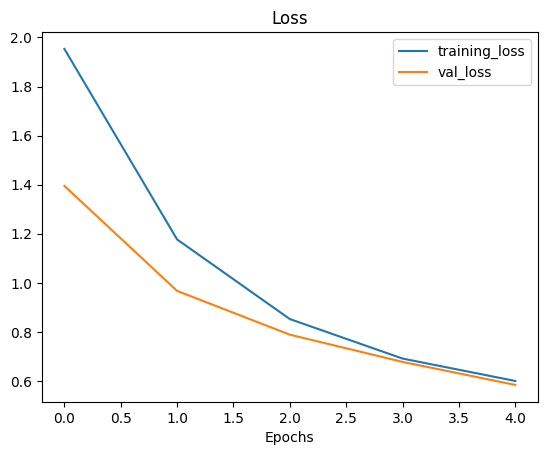

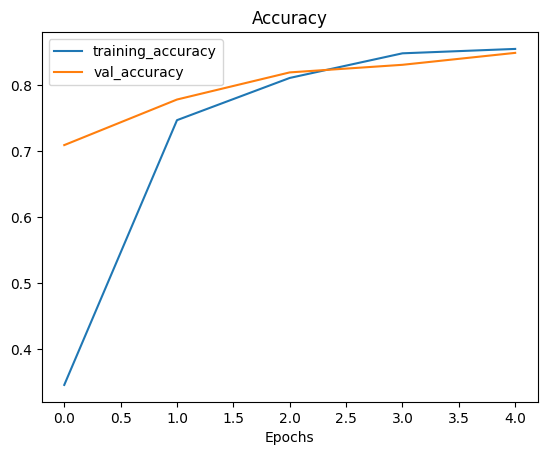

In [16]:
# Check out our model's training curve
plot_loss_curves(history_10_percent)

## Getting Feature vector from trained model

Let's demonstrate the global Average pooling 2D layer

In [17]:
# Define the input shape

input_shape = (1, 4, 4, 3)

# Create a random tensor
tf.random.set_seed(42)
input_tensor = tf.random.normal(input_shape)
print(f"Random inout tensor:\n {input_tensor}\n")

# Pass the random tensor through a global average pooling 2D layer
Gloabal_average_pooling_layer = tf.keras.layers.GlobalAveragePooling2D()(input_tensor)
print(f"2D global average pooled random tensor:\n {Gloabal_average_pooling_layer}\n")

# check shape of the different tensors
print(f"shape of input tensor: {input_tensor.shape}")
print(f"shape of Goble Average Pooled 2D tensor: {Gloabal_average_pooling_layer.shape}")

Random inout tensor:
 [[[[ 0.3274685  -0.8426258   0.3194337 ]
   [-1.4075519  -2.3880599  -1.0392479 ]
   [-0.5573232   0.539707    1.6994323 ]
   [ 0.28893656 -1.5066116  -0.26454744]]

  [[-0.59722406 -1.9171132  -0.62044144]
   [ 0.8504023  -0.40604794 -3.0258412 ]
   [ 0.9058464   0.29855987 -0.22561555]
   [-0.7616443  -1.891714   -0.9384712 ]]

  [[ 0.77852213 -0.47338897  0.97772694]
   [ 0.24694404  0.20573747 -0.5256233 ]
   [ 0.32410017  0.02545409 -0.10638497]
   [-0.6369475   1.1603122   0.2507359 ]]

  [[-0.41728497  0.40125778 -1.4145442 ]
   [-0.59318566 -1.6617213   0.33567193]
   [ 0.10815629  0.2347968  -0.56668764]
   [-0.35819843  0.88698626  0.5274477 ]]]]

2D global average pooled random tensor:
 [[-0.09368646 -0.45840445 -0.28855976]]

shape of input tensor: (1, 4, 4, 3)
shape of Goble Average Pooled 2D tensor: (1, 3)


In [18]:
# Let's replicate the GlobalAveragePool2d layer
tf.reduce_mean(input_tensor, axis=[1, 2])

<tf.Tensor: shape=(1, 3), dtype=float32, numpy=array([[-0.09368646, -0.45840445, -0.28855976]], dtype=float32)>

## Running a series of trs=ansfer learning experiments

1. `model_1` - use feature extrxtion transfer learning with 1% of the training data augmentation

2. `model_2` - use feature extraction transfer learning with 10% of the training with data augmentation.

3. `model_3` - use fine-tuning transfer learning on 10% of the training data with data augmentation

4. `model_4` - use fine-tuning transfer learning on 100% of the training data with augmentation


## Getting and preprocessing data for model_1

In [19]:
# Download and unzip data

# !wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_1_percent.zip
# unzip_data("10_food_classes_1_percent.zip")

In [20]:
# Create training and test dirs

train_dir_1_percent = "10_food_classes_1_percent/train"
test_dir = "10_food_classes_1_percent/test"

In [21]:
# How many images are we working with
walk_through_dir("10_food_classes_1_percent")

There are 2 directories and 0 images in '10_food_classes_1_percent'.
There are 10 directories and 0 images in '10_food_classes_1_percent\test'.
There are 0 directories and 250 images in '10_food_classes_1_percent\test\chicken_curry'.
There are 0 directories and 250 images in '10_food_classes_1_percent\test\chicken_wings'.
There are 0 directories and 250 images in '10_food_classes_1_percent\test\fried_rice'.
There are 0 directories and 250 images in '10_food_classes_1_percent\test\grilled_salmon'.
There are 0 directories and 250 images in '10_food_classes_1_percent\test\hamburger'.
There are 0 directories and 250 images in '10_food_classes_1_percent\test\ice_cream'.
There are 0 directories and 250 images in '10_food_classes_1_percent\test\pizza'.
There are 0 directories and 250 images in '10_food_classes_1_percent\test\ramen'.
There are 0 directories and 250 images in '10_food_classes_1_percent\test\steak'.
There are 0 directories and 250 images in '10_food_classes_1_percent\test\sushi'

In [22]:
# Setup Our data loaders

IMG_SIZE = (224, 224)
train_data_1_percent = tf.keras.preprocessing.image_dataset_from_directory(train_dir_1_percent,
                                                                           label_mode = "categorical",
                                                                           image_size=IMG_SIZE,
                                                                           batch_size=BATCH_SIZE)

test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                label_mode="categorical",
                                                                image_size=IMG_SIZE,
                                                                batch_size=BATCH_SIZE)

Found 70 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


## Adding data Augmentation right into the model

To add data augmentation right into models, we can use the layers inside:

* `tf.keras.layers.experimental.preprocessing()`

In [23]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing

# Create data augmentation stage with horizontal flipping , rotations , zooms , etc.
data_augmentation = keras.Sequential([
    preprocessing.RandomFlip("horizontal"),
    preprocessing.RandomRotation(0.2),
    preprocessing.RandomZoom(0.2),
    preprocessing.RandomHeight(0.2),
    preprocessing.RandomWidth(0.2),
], name="data_augmentation")

### Visualize our data augmentation layer

(-0.5, 566.5, 390.5, -0.5)

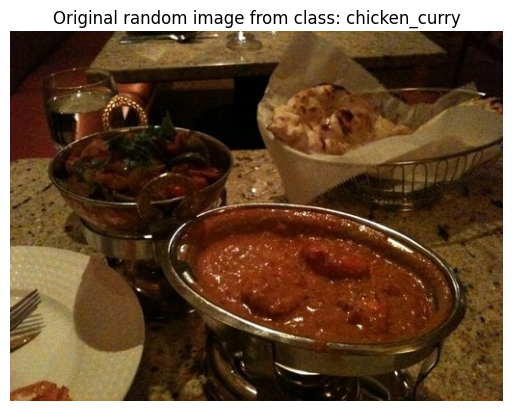

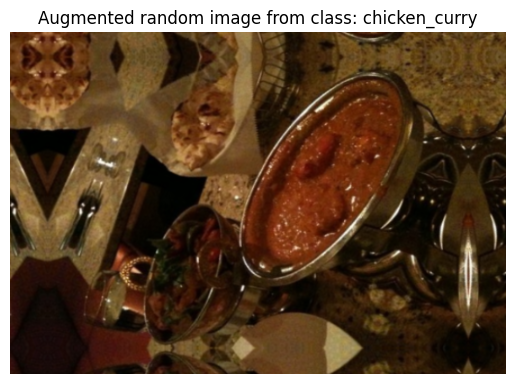

In [24]:
# View a random image and compare it to it's augmented version

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
import random

target_class = random.choice(train_data_1_percent.class_names)
target_dir = "10_food_classes_1_percent/train/" + target_class
random_image = random.choice(os.listdir(target_dir))
random_image_path = target_dir + "/" + random_image


# Read in the random image
img = mpimg.imread(random_image_path)
plt.imshow(img)
plt.title(f"Original random image from class: {target_class}")
plt.axis(False)


# No let,s plot our augmented andom image
augmented_img = data_augmentation(img, training = True)
plt.figure()
plt.imshow(augmented_img/255.)
plt.title(f"Augmented random image from class: {target_class}")
plt.axis(False)

## Model 1: Feature extraction tranfer learning on 1% of the data with data augmentation

In [25]:
# Steup input shape and base model , freezing the base model layers
input_shape = (224, 224, 3)

# Create base model
base_model = tf.keras.applications.efficientnet_v2.EfficientNetV2B0(include_top=False)
base_model.trainable = False

# Create the input layers
inputs = layers.Input(shape=input_shape, name="input_layers")

# Addin data augmentation Sequential model as layer
x = data_augmentation(inputs)

# Give base_model the inputs (after augmentation) and don't train it
x= base_model(x, training=False)

# pool output features of the base model
x = layers.GlobalAveragePooling2D(name= "global_average_pooling_layer")(x)

# Put a dense layer on as the output
outputs = layers.Dense(10, activation="softmax", name="output_layer")(x)

# Make model using the inputs and outputs
outputs = layers.Dense(10, activation="softmax", name="output_layer")(x)

# Make a model using the inputes and outputs

model_1 = keras.Model(inputs, outputs)

# Compile the model
model_1.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

# Fit the model
history_1_percent = model_1.fit(train_data_1_percent,
                                epochs=5,
                                steps_per_epoch= len(train_data_1_percent),
                                validation_data = test_data,
                                validation_steps=int(0.25 * len(test_data)),
                                # Track model training logs
                                callbacks=[create_tensorboard_callback(dir_name="transfer_learning",
                                                                       experiment_name="1_percentage_data_aug")])



Saving TensorBoard log files to: transfer_learning/1_percentage_data_aug/20231026-224418
Epoch 1/5
3/3 [==============================] - 15s 4s/step - loss: 2.3502 - accuracy: 0.0857 - val_loss: 2.1939 - val_accuracy: 0.1957
Epoch 2/5
3/3 [==============================] - 11s 5s/step - loss: 2.0768 - accuracy: 0.3000 - val_loss: 2.0815 - val_accuracy: 0.2730
Epoch 3/5
3/3 [==============================] - 12s 6s/step - loss: 1.9527 - accuracy: 0.4429 - val_loss: 1.9854 - val_accuracy: 0.3421
Epoch 4/5
3/3 [==============================] - 11s 5s/step - loss: 1.8340 - accuracy: 0.4714 - val_loss: 1.9034 - val_accuracy: 0.3783
Epoch 5/5
3/3 [==============================] - 11s 5s/step - loss: 1.6652 - accuracy: 0.5571 - val_loss: 1.8208 - val_accuracy: 0.4227


In [26]:
# Check the summary
model_1.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layers (InputLayer)   [(None, 224, 224, 3)]     0         
                                                                 
 data_augmentation (Sequent  (None, None, 3)           0         
 ial)                                                            
                                                                 
 efficientnetv2-b0 (Functio  (None, None, None, 1280   5919312   
 nal)                        )                                   
                                                                 
 global_average_pooling_lay  (None, 1280)              0         
 er (GlobalAveragePooling2D                                      
 )                                                               
                                                                 
 output_layer (Dense)        (None, 10)                1281

In [27]:
# Evalute on full test dataset
results_1_percentage_data_aug = model_1.evaluate(test_data)
results_1_percentage_data_aug

79/79 [==============================] - 39s 493ms/step - loss: 1.8139 - accuracy: 0.4384


[1.813870906829834, 0.438400000333786]

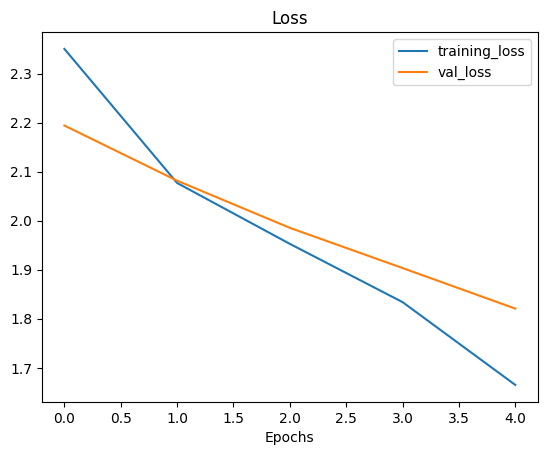

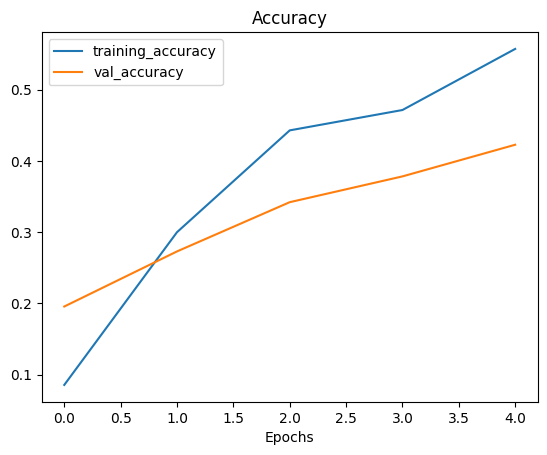

In [28]:
# How do the model with 1% of the data
plot_loss_curves(history_1_percent)

## Model 2: feature extraction tranfer learning model with 10% of data and daata augmentation


In [29]:
# # Get 10 percent of data
# !wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
# unzip_data(10_food_classes_10_percent.zip)

train_dir_10_percent ="10_food_classes_10_percent/train"
test_dir = "10_food_classes_10_percent/test"


In [30]:
# Set data inputs
import tensorflow as tf
IMG_SIZE = (224, 224)

train_data_10_percent = tf.keras.preprocessing.image_dataset_from_directory(train_dir_10_percent,
                                                                            label_mode="categorical",
                                                                            image_size=IMG_SIZE)

test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                label_mode= "categorical",
                                                                image_size=IMG_SIZE)

Found 750 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


In [31]:
# Get summary of data augmentation sequential model

data_augmentation.summary()

Model: "data_augmentation"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 random_flip (RandomFlip)    (384, 512, 3)             0         
                                                                 
 random_rotation (RandomRot  (384, 512, 3)             0         
 ation)                                                          
                                                                 
 random_zoom (RandomZoom)    (384, 512, 3)             0         
                                                                 
 random_height (RandomHeigh  (None, 512, 3)            0         
 t)                                                              
                                                                 
 random_width (RandomWidth)  (None, None, 3)           0         
                                                                 
Total params: 0 (0.00 Byte)
Trainable params: 0 (

In [32]:
# CVreate model 2 with data augmentation built in

from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.models import Sequential

# Build data augmentation layer

data_augmentation = Sequential([
    preprocessing.RandomFlip("horizontal"),
    preprocessing.RandomHeight(0.2),
    preprocessing.RandomWidth(0.2),
    preprocessing.RandomZoom(0.2),
    preprocessing.RandomRotation(0.2)
], name="data_augmentation")

# Setup the input shape to our model
input_shape = (224, 224, 3)

# Create a frozen base model (also called the backbone)
base_model = tf.keras.applications.efficientnet_v2.EfficientNetV2B0(include_top=False)
base_model.trainable = False

# create the input and outputs (including the layers in between)
inputs = layers.Input(shape=input_shape, name= "inpute_layer")
x = data_augmentation(inputs)# augment our training images (augmentation doesn't occur on test data)
x = base_model(x, training=False) # pass augmented images to base model but keep it in inferance mode, this also insures batchnorm layers don't get updated
x = layers.GlobalAveragePooling2D(name="global_average_pooling_2D")(x)
outputs = layers.Dense(10, activation="softmax", name="output_layer")(x)
model_2 = tf.keras.Model(inputs, outputs)

# Compile the model
model_2.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])




In [33]:
base_model.summary()

Model: "efficientnetv2-b0"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, None, None, 3)]      0         []                            
                                                                                                  
 rescaling_2 (Rescaling)     (None, None, None, 3)        0         ['input_3[0][0]']             
                                                                                                  
 normalization_2 (Normaliza  (None, None, None, 3)        0         ['rescaling_2[0][0]']         
 tion)                                                                                            
                                                                                                  
 stem_conv (Conv2D)          (None, None, None, 32)       864       ['normalizatio

### Creating a ModelCheckpoints
The ModelCheckpoint callback intermadietly saves our model (the full model or just the weights) during training. This is useful so we can come and start where we left off.





In [34]:
# Set checkpoint path

checkpoint_path = "ten_percent_model_checkpoints_weights/checkpoint.ckpt"

# Create a MOdelCheckpoint callback that saves the model's weights only
checkpoint_callbck = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                        save_weights_only=True,
                                                        save_best_only=False,
                                                        save_freq="epoch",
                                                        verbose=1)

In [35]:
## fit model 2 passing in the ModelCheckpoints every epoch
initial_epochs = 5

history_10_percent_data_aug = model_2.fit(train_data_10_percent,
                                          epochs=initial_epochs,
                                          validation_data=test_data,
                                          validation_steps= int(0.25 * len(test_data)),
                                          callbacks = [create_tensorboard_callback(dir_name = "transfer_learning",
                                                                                   experiment_name="10_percent_data_aug"),
                                                       checkpoint_callbck])


Saving TensorBoard log files to: transfer_learning/10_percent_data_aug/20231026-224601


Epoch 1/5
24/24 [==============================] - ETA: 0s - loss: 1.9854 - accuracy: 0.3493
Epoch 1: saving model to ten_percent_model_checkpoints_weights\checkpoint.ckpt
24/24 [==============================] - 29s 974ms/step - loss: 1.9854 - accuracy: 0.3493 - val_loss: 1.4711 - val_accuracy: 0.6579
Epoch 2/5
24/24 [==============================] - ETA: 0s - loss: 1.3764 - accuracy: 0.6547
Epoch 2: saving model to ten_percent_model_checkpoints_weights\checkpoint.ckpt
24/24 [==============================] - 22s 948ms/step - loss: 1.3764 - accuracy: 0.6547 - val_loss: 1.0352 - val_accuracy: 0.7664
Epoch 3/5
24/24 [==============================] - ETA: 0s - loss: 1.0715 - accuracy: 0.7400
Epoch 3: saving model to ten_percent_model_checkpoints_weights\checkpoint.ckpt
24/24 [==============================] - 22s 933ms/step - loss: 1.0715 - accuracy: 0.7400 - val_loss: 0.8499 - val_accuracy: 0.7977
Epoch 4/5
24/24 [==============================] - ETA: 0s - loss: 0.9111 - accuracy: 0.

In [36]:
# What were model_0 results?
model_0.evaluate(test_data)

79/79 [==============================] - 36s 452ms/step - loss: 0.5748 - accuracy: 0.8536


[0.5748327374458313, 0.853600025177002]

In [37]:
model_2.evaluate(test_data)

79/79 [==============================] - 35s 440ms/step - loss: 0.6605 - accuracy: 0.8236


[0.6605387926101685, 0.8235999941825867]

In [38]:
#Check model_2 results on all test data
results_10_percent_data_aug = model_2.evaluate(test_data)
results_10_percent_data_aug

79/79 [==============================] - 35s 436ms/step - loss: 0.6605 - accuracy: 0.8236


[0.6605387330055237, 0.8235999941825867]

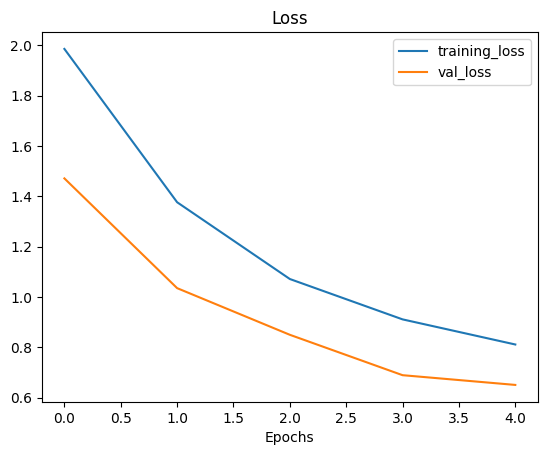

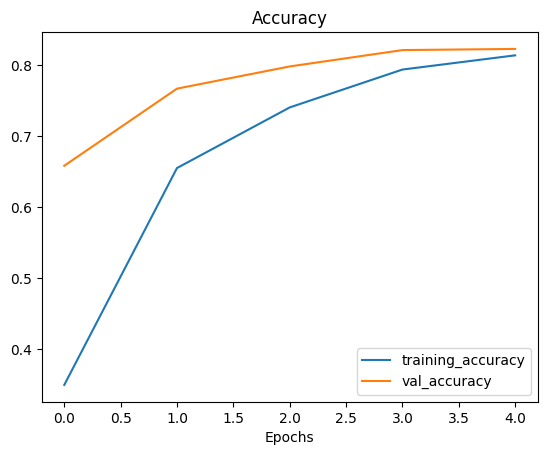

In [39]:
# Plot model curves
plot_loss_curves(history_10_percent_data_aug)

### Loading in checkpointed weights
Loading in checkpointted weights returns a model to a specific checkpoint

In [40]:
# Load in saved model weights and evaualte our model
model_2.load_weights(checkpoint_path)

In [41]:
# Evaluate model_2 with loaded weights
loaded_weights_model_results = model_2.evaluate(test_data)

79/79 [==============================] - 34s 433ms/step - loss: 0.6605 - accuracy: 0.8236


In [42]:
# If results from our previously evaluated model_2 match the loaded weights, everything has worked
results_10_percent_data_aug == loaded_weights_model_results

False

In [43]:
results_10_percent_data_aug

[0.6605387330055237, 0.8235999941825867]

In [44]:
loaded_weights_model_results

[0.660538911819458, 0.8235999941825867]

In [45]:
# Check to see if loaded model results are very close to our previous model results
import numpy as np
np.isclose(np.array(results_10_percent_data_aug), np.array(loaded_weights_model_results))

array([ True,  True])

In [46]:
# Check the differance between results
print(np.array(results_10_percent_data_aug) - np.array(loaded_weights_model_results))

[-1.78813934e-07  0.00000000e+00]


## Model_3: Fine-tunnig an existing model on 10% of the data
**Note**: Fine tunning usually works best after training a feature extraction model for a few epochs with large amounts of custum data


In [47]:
# layers in loaded model
model_2.layers

In [48]:
# Are these layers trainable?
for layer in model_2.layers:
    print(layer, layer.trainable)

<keras.src.engine.input_layer.InputLayer object at 0x00000262928DF6D0> True
<keras.src.engine.sequential.Sequential object at 0x00000262907FFF90> True
<keras.src.engine.functional.Functional object at 0x000002629287A3D0> False
<keras.src.layers.pooling.global_average_pooling2d.GlobalAveragePooling2D object at 0x000002629BE64690> True
<keras.src.layers.core.dense.Dense object at 0x0000026299E67CD0> True


In [49]:
# what layers are in our base_model (EfficientNetB0) and are they trainable?
for i, layer in enumerate(model_2.layers[2].layers):
    print(i, layer.name, layer.trainable)


0 input_3 False
1 rescaling_2 False
2 normalization_2 False
3 stem_conv False
4 stem_bn False
5 stem_activation False
6 block1a_project_conv False
7 block1a_project_bn False
8 block1a_project_activation False
9 block2a_expand_conv False
10 block2a_expand_bn False
11 block2a_expand_activation False
12 block2a_project_conv False
13 block2a_project_bn False
14 block2b_expand_conv False
15 block2b_expand_bn False
16 block2b_expand_activation False
17 block2b_project_conv False
18 block2b_project_bn False
19 block2b_drop False
20 block2b_add False
21 block3a_expand_conv False
22 block3a_expand_bn False
23 block3a_expand_activation False
24 block3a_project_conv False
25 block3a_project_bn False
26 block3b_expand_conv False
27 block3b_expand_bn False
28 block3b_expand_activation False
29 block3b_project_conv False
30 block3b_project_bn False
31 block3b_drop False
32 block3b_add False
33 block4a_expand_conv False
34 block4a_expand_bn False
35 block4a_expand_activation False
36 block4a_dwconv2 

In [50]:
# How many trainable variables are in base model?
print(len(model_2.layers[2].trainable_variables))

0


In [51]:
# to begin fine-tuning , let's start by setting the last 10 ayers of our base_model.trainable = True
base_model.trainable = True

# Freeze all layer except for the last 10
for layer in base_model.layers[:-10]:
    layer.trainable = False

# Recompile (we have to recompile our model every time we make change)
model_2.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), # during fine tuning lower the learning rate
                metrics=["accuracy"])



In [52]:
for i, layer in enumerate(model_2.layers[2].layers):
    print(i, layer.name, layer.trainable)

0 input_3 False
1 rescaling_2 False
2 normalization_2 False
3 stem_conv False
4 stem_bn False
5 stem_activation False
6 block1a_project_conv False
7 block1a_project_bn False
8 block1a_project_activation False
9 block2a_expand_conv False
10 block2a_expand_bn False
11 block2a_expand_activation False
12 block2a_project_conv False
13 block2a_project_bn False
14 block2b_expand_conv False
15 block2b_expand_bn False
16 block2b_expand_activation False
17 block2b_project_conv False
18 block2b_project_bn False
19 block2b_drop False
20 block2b_add False
21 block3a_expand_conv False
22 block3a_expand_bn False
23 block3a_expand_activation False
24 block3a_project_conv False
25 block3a_project_bn False
26 block3b_expand_conv False
27 block3b_expand_bn False
28 block3b_expand_activation False
29 block3b_project_conv False
30 block3b_project_bn False
31 block3b_drop False
32 block3b_add False
33 block4a_expand_conv False
34 block4a_expand_bn False
35 block4a_expand_activation False
36 block4a_dwconv2 

In [53]:
model_2.trainable_variables

[<tf.Variable 'block6h_se_reduce/kernel:0' shape=(1, 1, 1152, 48) dtype=float32, numpy=
 array([[[[-0.00207604,  0.01300672,  0.02047416, ..., -0.02240255,
           -0.07708141, -0.00094655],
          [-0.06357138,  0.0959678 , -0.05430871, ..., -0.01352078,
           -0.05987524, -0.11093444],
          [ 0.0068749 , -0.04681807, -0.01513974, ...,  0.03073284,
           -0.01280731,  0.03616464],
          ...,
          [ 0.11381665,  0.00804447, -0.05432149, ...,  0.08015257,
           -0.06561387, -0.05522665],
          [-0.12468243,  0.06938899, -0.07634895, ...,  0.01121222,
           -0.0128268 ,  0.10406019],
          [-0.04722364,  0.10557885,  0.16247186, ...,  0.04582691,
            0.01228108, -0.04941604]]]], dtype=float32)>,
 <tf.Variable 'block6h_se_reduce/bias:0' shape=(48,) dtype=float32, numpy=
 array([ 0.04594925,  2.5461788 , -1.426646  , -0.7885664 , -0.24730209,
        -0.5630991 , -0.6161863 , -0.4029834 , -1.4444699 , -1.0481553 ,
        -0.21704195,

In [54]:
# Now we'have unfrozen some layers , we can check the trainable layer count
print(len(model_2.trainable_variables))

12


In [55]:
# Fine tune for another 5 epochs
fine_tune_epochs = initial_epochs + 5

# Refit the model (same as model_2 execpt with more trainable layers)
history_fine_10_percent_data_aug = model_2.fit(train_data_10_percent,
                                               epochs=fine_tune_epochs,
                                               validation_data=test_data,
                                               validation_steps=int(0.25 * len(test_data)),
                                               initial_epoch=history_10_percent_data_aug.epoch[-1], # Start training from previous model
                                               callbacks=[create_tensorboard_callback(dir_name="transfer_learning",
                                                                                        experiment_name="10_percent_fine_tune_last_10")])



Saving TensorBoard log files to: transfer_learning/10_percent_fine_tune_last_10/20231026-225020
Epoch 5/10
24/24 [==============================] - 27s 869ms/step - loss: 0.6988 - accuracy: 0.8160 - val_loss: 0.5000 - val_accuracy: 0.8322
Epoch 6/10
24/24 [==============================] - 21s 896ms/step - loss: 0.5706 - accuracy: 0.8347 - val_loss: 0.4381 - val_accuracy: 0.8470
Epoch 7/10
24/24 [==============================] - 21s 888ms/step - loss: 0.5490 - accuracy: 0.8267 - val_loss: 0.4905 - val_accuracy: 0.8289
Epoch 8/10
24/24 [==============================] - 21s 889ms/step - loss: 0.5107 - accuracy: 0.8427 - val_loss: 0.4282 - val_accuracy: 0.8487
Epoch 9/10
24/24 [==============================] - 22s 944ms/step - loss: 0.4288 - accuracy: 0.8800 - val_loss: 0.4041 - val_accuracy: 0.8503
Epoch 10/10
24/24 [==============================] - 22s 940ms/step - loss: 0.4377 - accuracy: 0.8547 - val_loss: 0.4361 - val_accuracy: 0.8421


In [56]:
# Evaluate the fine_tune model(model_3 which is actually model_2 fine-tune for another 5 epochs)
results_fine_tune_10_percent = model_2.evaluate(test_data)

79/79 [==============================] - 37s 471ms/step - loss: 0.4558 - accuracy: 0.8448


In [57]:
results_10_percent_data_aug

[0.6605387330055237, 0.8235999941825867]

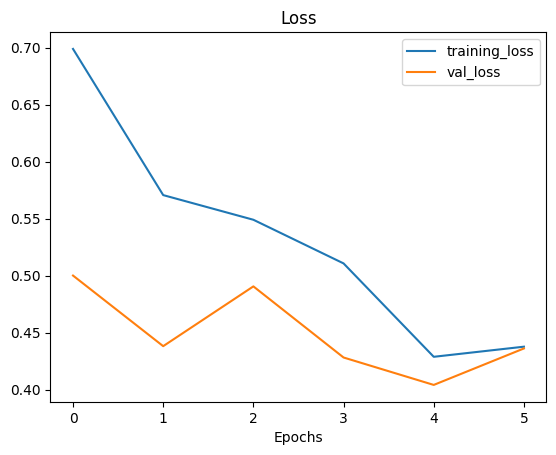

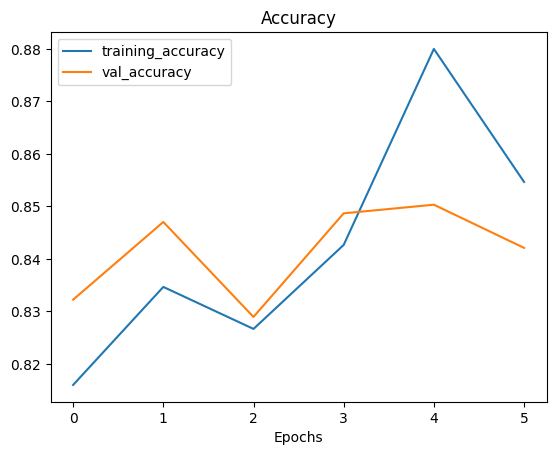

In [58]:
# check loss curves
plot_loss_curves(history_fine_10_percent_data_aug)

plot `Plot_loss_curves` function works greate with models which have only been fit once , however , we want something to copare one series of running `fit()` with another (e.g. before and after fine tuning)

In [59]:
# Let's create a function tp copare training histories

def compare_historys(original_history, new_history, initial_epochs):
    """
    Compares two TensorFlow History objects
    """

    # Get original history measurements
    acc = original_history.history["accuracy"]
    loss = original_history.history["loss"]

    val_acc = original_history.history["val_accuracy"]
    val_loss = original_history.history["val_loss"]

    # combine original history metrics with new_history metrics
    total_acc = acc + new_history.history["accuracy"]
    total_loss = loss + new_history.history["loss"]
        
    total_val_acc = acc + new_history.history["val_accuracy"]
    total_val_loss = loss + new_history.history["val_loss"]

    # Make plot acuuracy
    plt.figure(figsize=(8,8))
    plt.subplot(2,1,1)
    plt.plot(total_acc, label="Training Accuracy")
    plt.plot(total_val_acc, label="Validation Accuracy")
    plt.plot([initial_epochs-1, initial_epochs-1], plt.ylim(), label="start Fine Tuning")
    plt.legend(loc="lower right")
    plt.title("Training and Validation Accuracy")

    # Make plot loss
    plt.figure(figsize=(8,8))
    plt.subplot(2,1,2)
    plt.plot(total_loss, label="Training Loss")
    plt.plot(total_val_loss, label="Validation Loss")
    plt.plot([initial_epochs-1, initial_epochs-1], plt.ylim(), label="start Fine Tuning")
    plt.legend(loc="upper right")
    plt.title("Training and Validation Loss")

    



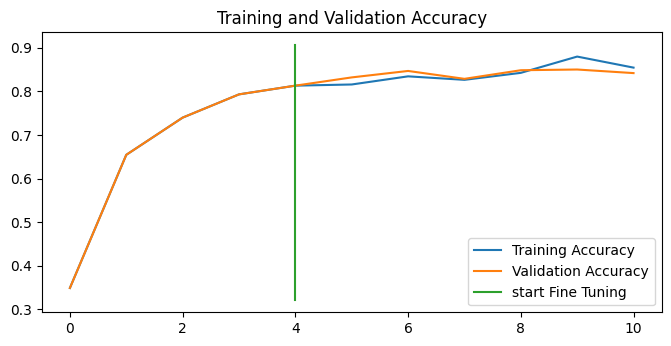

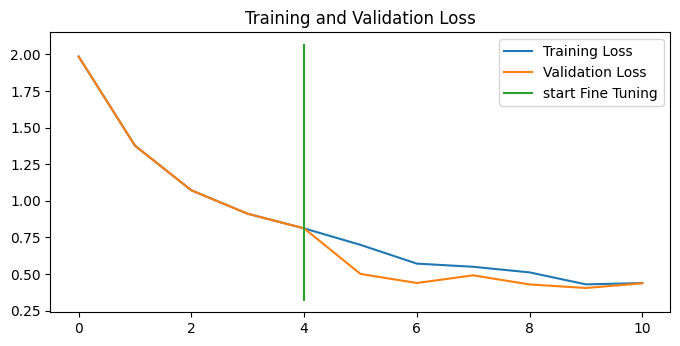

In [60]:
compare_historys(history_10_percent_data_aug, history_fine_10_percent_data_aug, initial_epochs=5)

### Model 4: Fine- tunning and existing model on all of the data


In [61]:
# Download and unzip the data
# !wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_all_data.zip

In [62]:
# Setup training and test dir
train_dir_all_data = "10_food_classes_all_data/train"
test_dir = "10_food_classes_all_data/test"

In [63]:
# How many images are we working with now?
walk_through_dir("10_food_classes_all_data")

There are 3 directories and 0 images in '10_food_classes_all_data'.
There are 10 directories and 0 images in '10_food_classes_all_data\test'.
There are 0 directories and 250 images in '10_food_classes_all_data\test\chicken_curry'.
There are 0 directories and 250 images in '10_food_classes_all_data\test\chicken_wings'.
There are 0 directories and 250 images in '10_food_classes_all_data\test\fried_rice'.
There are 0 directories and 250 images in '10_food_classes_all_data\test\grilled_salmon'.
There are 0 directories and 250 images in '10_food_classes_all_data\test\hamburger'.
There are 0 directories and 250 images in '10_food_classes_all_data\test\ice_cream'.
There are 0 directories and 250 images in '10_food_classes_all_data\test\pizza'.
There are 0 directories and 250 images in '10_food_classes_all_data\test\ramen'.
There are 0 directories and 250 images in '10_food_classes_all_data\test\steak'.
There are 0 directories and 250 images in '10_food_classes_all_data\test\sushi'.
There are 

In [64]:
# Setup data inputs
import tensorflow as tf
IMG_SIZE = (224, 224)
train_data_10_classes_full = tf.keras.preprocessing.image_dataset_from_directory(train_dir_all_data,
                                                                                 label_mode="categorical",
                                                                                 image_size=IMG_SIZE)

test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                label_mode="categorical",
                                                                image_size=IMG_SIZE)

Found 7500 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


In [65]:
# Evaluate model_2 (this is the fine-tuned on 10 percentage of data version)
model_2.evaluate(test_data)

79/79 [==============================] - 38s 475ms/step - loss: 0.4558 - accuracy: 0.8448


[0.45575931668281555, 0.8447999954223633]

In [66]:
results_fine_tune_10_percent

[0.4557592272758484, 0.8447999954223633]

To train a finetuning model (model_4) we need to revert model_2 back to it's feature extraction weights.

In [69]:
# Load weights from check points, that way we can fine-tune from
# the same stage the 10 percent data model was fine-tuned from

model_2.load_weights(checkpoint_path)

ValueError: Received incompatible tensor with shape (1280, 10) when attempting to restore variable with shape (1, 1, 1152, 48) and name Adam/m/block6h_se_reduce/kernel:0.

In [70]:
model_2.evaluate(test_data)

79/79 [==============================] - 25s 316ms/step - loss: 0.6605 - accuracy: 0.8236


[0.6605387330055237, 0.8235999941825867]

In [71]:
# check to see if our model_2 has been reverted back to feature extraction results
results_10_percent_data_aug

[0.6605387330055237, 0.8235999941825867]

In [72]:
# Check which s are tunable in the whole model

for layer_number, layer in enumerate(model_2.layers):
    print(layer_number, layer.name, layer.trainable)

0 inpute_layer True
1 data_augmentation True
2 efficientnetv2-b0 True
3 global_average_pooling_2D True
4 output_layer True


In [73]:
# Let'e drill into our base model (efficientnetb0) and see what layers are trainable
for layer_number, layer in enumerate(model_2.layers[2].layers):
    print(layer_number, layer.name, layer.trainable)

0 input_3 False
1 rescaling_2 False
2 normalization_2 False
3 stem_conv False
4 stem_bn False
5 stem_activation False
6 block1a_project_conv False
7 block1a_project_bn False
8 block1a_project_activation False
9 block2a_expand_conv False
10 block2a_expand_bn False
11 block2a_expand_activation False
12 block2a_project_conv False
13 block2a_project_bn False
14 block2b_expand_conv False
15 block2b_expand_bn False
16 block2b_expand_activation False
17 block2b_project_conv False
18 block2b_project_bn False
19 block2b_drop False
20 block2b_add False
21 block3a_expand_conv False
22 block3a_expand_bn False
23 block3a_expand_activation False
24 block3a_project_conv False
25 block3a_project_bn False
26 block3b_expand_conv False
27 block3b_expand_bn False
28 block3b_expand_activation False
29 block3b_project_conv False
30 block3b_project_bn False
31 block3b_drop False
32 block3b_add False
33 block4a_expand_conv False
34 block4a_expand_bn False
35 block4a_expand_activation False
36 block4a_dwconv2 

In [74]:
# compile
model_2.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                metrics=["accuracy"])

In [79]:
# Continue to train and fine-tune the model to our data(100% of training data)
fine_tune_epochs = initial_epochs + 5

history_fine_10_classes_full = model_2.fit(train_data_10_classes_full,
                                       epochs = fine_tune_epochs,
                                       validation_data=test_data,
                                       validation_steps= int(0.25 * len(test_data)),
                                       initial_epochs = history_fine_10_percent_data_aug.epoch[-1],
                                       callbacks=[create_tensorboard_callback(dir_name="transfer_learning",
                                                                              experiment_name="full_10_classes_fine_tune_last_10")])

Saving TensorBoard log files to: transfer_learning/full_10_classes_fine_tune_last_10/20231026-232909
Unexpected exception formatting exception. Falling back to standard exception


Traceback (most recent call last):
  File "c:\Users\ADMIN\anaconda3\envs\tf\Lib\site-packages\IPython\core\interactiveshell.py", line 3526, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "C:\TEMP\ipykernel_17552\2375508112.py", line 4, in <module>
    history_fine_10_classes_full = model_2.fit(train_data_10_classes_full,
                                   ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\ADMIN\anaconda3\envs\tf\Lib\site-packages\keras\src\utils\traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "c:\Users\ADMIN\anaconda3\envs\tf\Lib\site-packages\keras\src\utils\traceback_utils.py", line 67, in error_handler
    filtered_tb = _process_traceback_frames(e.__traceback__)
                  ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
TypeError: Model.fit() got an unexpected keyword argument 'initial_epochs'

During handling of the above exception, another exception occurred:

Traceback (most

In [78]:
model_2.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inpute_layer (InputLayer)   [(None, 224, 224, 3)]     0         
                                                                 
 data_augmentation (Sequent  (None, None, None, 3)     0         
 ial)                                                            
                                                                 
 efficientnetv2-b0 (Functio  (None, None, None, 1280   5919312   
 nal)                        )                                   
                                                                 
 global_average_pooling_2D   (None, 1280)              0         
 (GlobalAveragePooling2D)                                        
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                           